<h1>Table of contents</h1>

<div class="alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#load_dataset">Load the Cancer data</a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#evaluation">Evaluation</a></li>
        <li><a href="#practice">Practice</a></li>
    </ol>
</div>
<br>
<hr>

In [79]:
# Import library
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

print('imported')

imported


## Load the data

In [80]:
# download the data
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2020-10-12 05:09:23--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

100%[======================================>] 20,675      --.-K/s   in 0.001s  

2020-10-12 05:09:24 (15.1 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



In [81]:
# read data from the .csv file
cell_df = pd.read_csv("cell_samples.csv")
cell_df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


<h2 id="load_dataset">Load the Cancer data</h2>
The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

| Field name  | Description                 |
| ----------- | --------------------------- |
| ID          | Clump thickness             |
| Clump       | Clump thickness             |
| UnifSize    | Uniformity of cell size     |
| UnifShape   | Uniformity of cell shape    |
| MargAdh     | Marginal adhesion           |
| SingEpiSize | Single epithelial cell size |
| BareNuc     | Bare nuclei                 |
| BlandChrom  | Bland chromatin             |
| NormNucl    | Normal nucleoli             |
| Mit         | Mitoses                     |
| Class       | Benign or malignant         |

<br>
The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign (harmless).

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

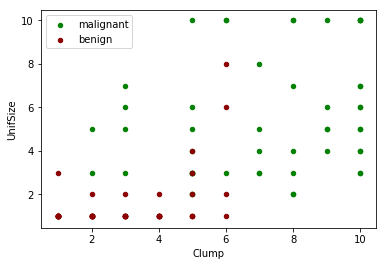

In [82]:
ax = cell_df[cell_df['Class'] == 4][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='green', label='malignant');

cell_df[cell_df['Class'] == 2][0:50].plot(kind='scatter', x='Clump', y='UnifSize', color='darkred', label='benign', ax=ax);

plt.show()

## Data pre-processing and selection

In [83]:
# look at columns data types
cell_df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the **BareNuc** column includes some values that are not numerical. Convert those rows into 'int'.

In [84]:
cell_df = cell_df[pd.to_numeric(cell_df['BareNuc'], errors='coerce').notnull()]

cell_df['BareNuc'] = cell_df['BareNuc'].astype('int')

cell_df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [85]:
feature_df = cell_df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc', 'BlandChrom', 'NormNucl', 'Mit']]
X = np.asarray(feature_df)
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [86]:
cell_df['Class'] = cell_df['Class'].astype('int')

y = np.asarray(cell_df['Class'])
y [0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset 

In [87]:
# Train/Test split 70/30
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)

print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (478, 9) (478,)
Test set: (205, 9) (205,)


## Modeling (SVM with Scikit-learn )

The SVM algorithm offers a choice of kernel functions for performing its processing. Mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

kernel:{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’}

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. 

In [88]:
from sklearn import svm
clf = svm.SVC(kernel='linear')
clf.fit(X_train, y_train) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [89]:
# use model to predict new values
yhat = clf.predict(X_test)
yhat [0:5]

array([2, 4, 2, 4, 2])

## Evaluation

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [91]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.98      0.92      0.95       132
           4       0.88      0.96      0.92        73

   micro avg       0.94      0.94      0.94       205
   macro avg       0.93      0.94      0.93       205
weighted avg       0.94      0.94      0.94       205

Confusion matrix, without normalization
[[122  10]
 [  3  70]]


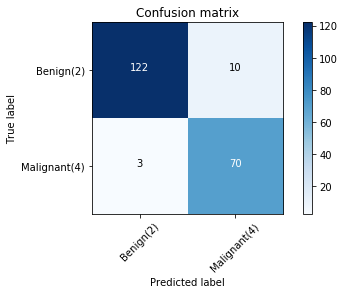

In [92]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [93]:
# use the f1_score from sklearn library
from sklearn.metrics import f1_score
print("Average F1-Score: %.4f" %f1_score(y_test, yhat, average='weighted')) 

Average F1-Score: 0.9372


In [94]:
# try jaccard index for accuracy
from sklearn.metrics import jaccard_similarity_score
print("Jaccard Score: %.4f" %jaccard_similarity_score(y_test, yhat))


Jaccard Score: 0.9366


In [95]:
# try accuracy_score 
from sklearn.metrics import accuracy_score
print("Accuracy-Score: %.4f" % accuracy_score(y_test, yhat))

Accuracy-Score: 0.9366
